In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import plotly.express as px
from geopy import Point, distance
from math import *
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("uber.csv")

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df = df.drop(["Unnamed: 0", "key"], axis=1)

In [5]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [7]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,200000.0,11.359955,9.901776,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,200000.0,-72.527638,11.437787,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,200000.0,39.935885,7.720539,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,200000.0,1.684535,1.385997,0.000000,1.000000,1.000000,2.000000,208.000000


In [9]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    distance = []
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1 
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        distance.append(c)
    return distance

In [12]:
df["distance_km"] = distance_transform(df["pickup_longitude"].to_numpy(), 
                                       df["pickup_latitude"].to_numpy(), 
                                       df["dropoff_longitude"].to_numpy(), 
                                       df["dropoff_latitude"].to_numpy())
 

In [13]:
df = df.assign(pickup_hr = df.pickup_datetime.dt.hour, 
               day= df.pickup_datetime.dt.day, 
               month = df.pickup_datetime.dt.month, 
               year = df.pickup_datetime.dt.year, 
               day_of_week = df.pickup_datetime.dt.dayofweek, 
               day_name=df.pickup_datetime.dt.day_name())

In [14]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hr,day,month,year,day_of_week,day_name
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,19,7,5,2015,3,Thursday
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,20,17,7,2009,4,Friday
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,21,24,8,2009,0,Monday
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,8,26,6,2009,4,Friday
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,17,28,8,2014,3,Thursday


In [15]:
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR)))]
    return outliers

In [16]:
outliers = find_outliers(df['fare_amount'])
print('number of outliers:' + str(len(outliers)))
print('max outlier value:' + str(outliers.max()))
print('min outlier value:' + str(outliers.min()))
outliers

number of outliers:17166
max outlier value:499.0
min outlier value:-52.0


6         24.50
30        25.70
34        39.50
39        29.00
48        56.80
          ...  
199976    49.70
199977    43.50
199982    57.33
199985    24.00
199997    30.90
Name: fare_amount, Length: 17166, dtype: float64

In [17]:
outliers = find_outliers(df['passenger_count'])
print('number of outliers:' + str(len(outliers)))
print('max outlier value:' + str(outliers.max()))
print('min outlier value:' + str(outliers.min()))
outliers

number of outliers:22557
max outlier value:208
min outlier value:4


4         5
6         5
12        5
24        5
29        5
         ..
199958    5
199959    5
199962    4
199969    5
199985    5
Name: passenger_count, Length: 22557, dtype: int64

In [18]:
df.drop(df[df['distance_km'] == 0].index, inplace = True)
df.drop(df[df['distance_km'] > 60].index, inplace = True)
df.drop(df[df['fare_amount'] > 100].index, inplace = True)
df.drop(df[df['fare_amount'] < 0].index, inplace = True)
df.drop(df[df['passenger_count'] > 6].index, inplace = True)

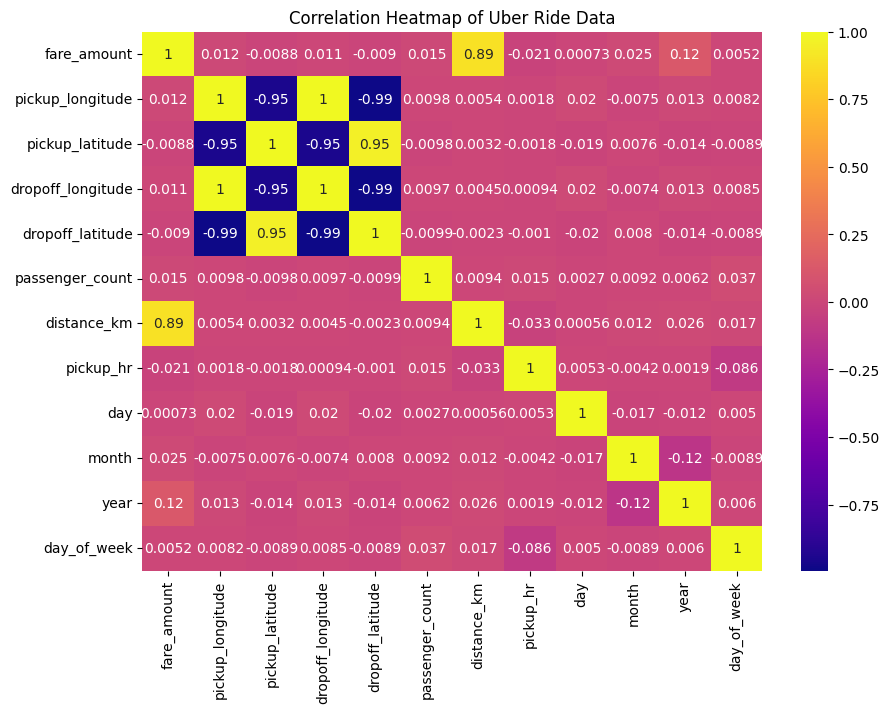

In [19]:
# Create correlation matrix using only numeric columns
numeric_columns = [
    "fare_amount",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "distance_km",
    "pickup_hr",
    "day",
    "month",
    "year",
    "day_of_week",
]
correlation_matrix = df[numeric_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="plasma", center=0)
plt.title("Correlation Heatmap of Uber Ride Data")
plt.show()

In [20]:
x = df[["year", "distance_km"]]
y = df["fare_amount"]

In [21]:
scaler = StandardScaler()

In [22]:
x = scaler.fit_transform(x)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=42)

In [24]:
model = LinearRegression()
model.fit(x_train, y_train)
scaler = StandardScaler()

In [25]:
y_pred = model.predict(x_test)

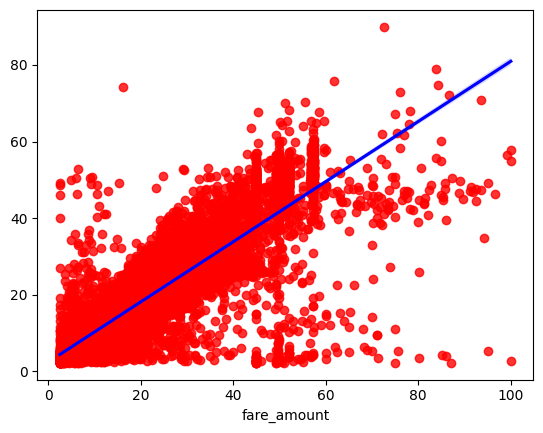

In [26]:
sns.regplot(x=y_test, y=y_pred, color="red", line_kws={"color" : "blue"})
plt.show()

In [27]:
print(f"Mean absolute error {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared error {metrics.mean_squared_error(y_test, y_pred)}")
print(f"Root mean squared error {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

Mean absolute error 2.24387950345949
Mean squared error 18.323819106454565
Root mean squared error 4.280633026370581


In [28]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [29]:
y_pred = model.predict(x_test)

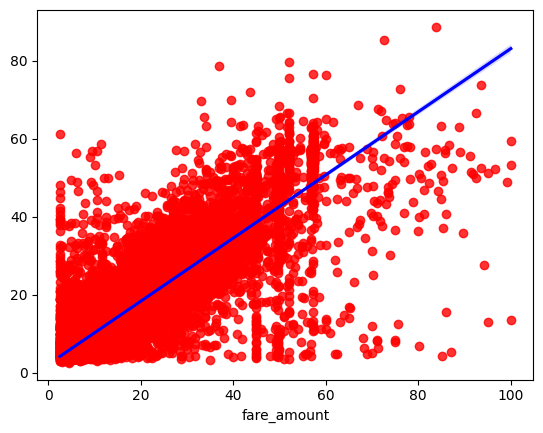

In [30]:
sns.regplot(x=y_test, y=y_pred, color="red", line_kws={"color" : "blue"})
plt.show()

In [32]:
print(f"Mean absolute error {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared error {metrics.mean_squared_error(y_test, y_pred)}")
print(f"Root mean squared error {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

Mean absolute error 2.4975183654344444
Mean squared error 21.270589684762548
Root mean squared error 4.612004952812014
